# H&M Recommendation Customer Clustering by Kmeans

Thank you for looking my notebook.  
This notebook is made with reference to　[By HechtJP -Rule-Base-by-Customer-Age](https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age).

This notebook is my first public notebook.
If this notebook helps you, I would appreciate your comments and up votes.

## 1.Library

In [1]:
import sys, warnings, time, os, copy, gc, re, random, pickle, cudf
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from datetime import datetime, timedelta
import cudf

from sklearn.cluster import KMeans
from sklearn import preprocessing

## 2.Clutering

There are preprocessing and clustering here.
- preprocessing
|columns|conversion|
|:-:|:-:|
|fashion_news_frequency|{np.nan :0, 'None':0, 'Monthly':1, 'Regularly':2}|
|club_member_status|{np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':-1}|
|age|{np.nan:-1}|
|FN|{np.nan:0}|
|Active|{np.nan:0}|

- clustering
    - Normarization
        1. StandardScaler
        1. minMax
        1. None
    - parameters
        1. random_state:2022
        1. clusters:12


In [2]:
class Clustering_HandM():
    def customers_preprocessing(self, customers, dropcol=['postal_code'] , **kwargs):
        customers = customers.drop(dropcol, axis=1)
        customers_col = list(customers.columns)
        
        if 'fashion_news_frequency' in customers_col :
            customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('NONE','None')
            customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({np.nan :0, 'None':0, 'Monthly':1, 'Regularly':2})
            
        if 'club_member_status' in customers_col:
            customers['club_member_status'] = customers['club_member_status'].replace({np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':-1})
            
        if 'age' in customers_col:
            customers['age'] = customers['age'].fillna(-1)
            
        if 'FN' in customers_col:
            customers['FN'] = customers['FN'].fillna(0)

        if 'Active' in customers_col:
            customers['Active'] = customers['Active'].fillna(0)
            
            print(f'###NULL DESCRIPTION###\n{customers.isnull().sum()}')
            
        return customers
    
    def clustering(self, df, predcol, usecol, normmethod='StandardScaler', clusters=12, DEBUG=False):
        
        X = np.array(df[usecol])
        
        if normmethod == 'StandardScaler':
            nm = preprocessing.StandardScaler()
            X = nm.fit_transform(X)
        elif normmethod == 'minMax':
            nm = preprocessing.MinMaxScaler()
            X = nm.fit_transform(X)
        print(f'NormarlizationMethod:{normmethod}')
        
        km = KMeans(n_clusters=clusters, random_state=2022)
        km.fit(X)
        print('Distortion: %.2f'% km.inertia_)

        pred = km.labels_
        df_pred = pd.DataFrame(pred, columns=['pred'])
        df_pred = pd.concat([df, df_pred], axis=1)
        
        df_norm = pd.DataFrame(X, columns=usecol)
        print(df_norm.describe())


        if DEBUG:
            df_norm = pd.concat([df[predcol], df_norm], axis=1)
            return df_pred, df_norm
        else:
            return df_pred


In [5]:
DEBUG = False
PATH_INPUT = r'../dataset/'

In [6]:
customers = pd.read_csv(PATH_INPUT + 'customers.csv')

clst = Clustering_HandM()
customers = clst.customers_preprocessing(customers)

usecol = ['club_member_status', 'fashion_news_frequency', 'age', 'FN', 'Active']
predcol = ['customer_id']

dfCustomers = clst.clustering(customers, predcol=predcol, usecol=usecol, )

###NULL DESCRIPTION###
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
dtype: int64
NormarlizationMethod:StandardScaler
Distortion: 215064.47
       club_member_status  fashion_news_frequency           age            FN  \
count        1.371980e+06            1.371980e+06  1.371980e+06  1.371980e+06   
mean         6.477082e-15           -1.226199e-15 -8.864969e-17  3.345628e-15   
std          1.000000e+00            1.000000e+00  1.000000e+00  1.000000e+00   
min         -1.017633e+01           -7.312792e-01 -2.500119e+00 -7.299677e-01   
25%          2.702679e-01           -7.312792e-01 -8.087807e-01 -7.299677e-01   
50%          2.702679e-01           -7.312792e-01 -3.352061e-01 -7.299677e-01   
75%          2.702679e-01            1.368392e+00  8.825574e-01  1.369924e+00   
max          2.702679e-01            1.368392e+00  4.265234e+00  1.369924e+00   

        

## 3.Comparison of Age_bins and ClusteringPred

In [7]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
dfCustomers['age_bins'] = pd.cut(dfCustomers['age'], listBin)

In [8]:
pd.crosstab(dfCustomers['pred'], dfCustomers['age_bins'])

age_bins,"(-1, 19]","(19, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 119]"
pred,,,,,,,
0,44051,203970,0,0,0,0,0
1,0,0,0,18252,80901,29081,8035
2,0,0,3987,16279,17716,5152,1374
3,0,0,0,0,61671,37126,9441
4,25355,173531,22165,0,0,0,0
5,0,121004,133438,0,0,0,0
6,160,1348,803,783,628,200,51
7,16,861,1113,1328,1690,719,226
8,1130,21436,12864,0,0,0,0


In [9]:
dfCustomers = dfCustomers.drop(['age_bins'], axis=1)

## 4.EDA of recent popular articles of each Pred
[Reference](https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age)

In [10]:
dfTransactions = cudf.read_csv(PATH_INPUT + 'transactions_train.csv',  
                               usecols=['t_dat', 'customer_id', 'article_id'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
dfTransactions['t_dat'] = cudf.to_datetime(dfTransactions['t_dat'])
dfTransactions.set_index('t_dat', inplace=True)
dfTransactions.head()

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /workspace/.conda-bld/work/include/rmm/mr/device/cuda_memory_resource.hpp:70: cudaErrorMemoryAllocation out of memory

In [ ]:
dfRecent = dfTransactions.loc['2020-09-01' : '2020-09-21']
dfRecent.head()

,customer_id,article_id
t_dat,,
2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,777148006
2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,835801001
2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,923134005
2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,865929003
2020-09-01,0005ed68483efa39644c45185550a82dd09acb07622acb...,863646004


In [ ]:
dfRecent = dfRecent.to_pandas()
# dfRecent = dfRecent.merge(dfCustomers[['customer_id', 'age_bins']], on='customer_id', how='inner')
dfRecent = dfRecent.merge(dfCustomers[['customer_id', 'pred']], on='customer_id', how='inner')
dfRecent.head()

,customer_id,article_id,pred
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,777148006,11
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,835801001,11
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,923134005,11
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,865929003,11
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,572998013,11


In [ ]:
dfRecent = dfRecent.groupby(['pred', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})
listUniBins = dfRecent['pred'].unique().tolist()

dict100 = {}
for uniBin in listUniBins:
    # dfTemp = dfRecent[dfRecent['age_bins'] == uniBin]
    dfTemp = dfRecent[dfRecent['pred'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})

<AxesSubplot:>

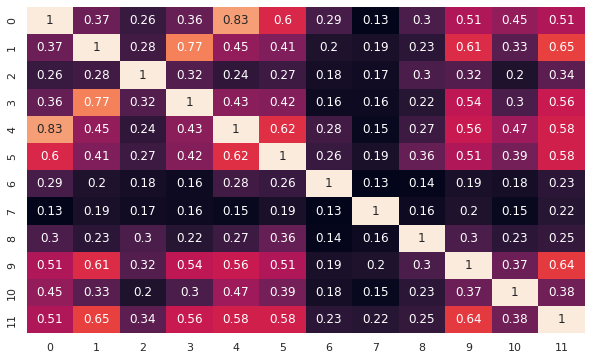

In [ ]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False)

## 5.Prediction
[H&M EDA & Rule Base by Customer Age](https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age)
[H&M: Faster Trending Products Weekly](https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook)

In [ ]:
N = 12
listUniBins = dfCustomers['pred'].unique().tolist()

In [ ]:
for uniBin in listUniBins:
    df  = cudf.read_csv('dataset/transactions_train.csv',
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    if str(uniBin) == 'nan':
        dfCustomersTemp = dfCustomers[dfCustomers['pred'].isnull()]
    else:
        dfCustomersTemp = dfCustomers[dfCustomers['pred'] == uniBin]
    
    dfCustomersTemp = dfCustomersTemp.drop(['pred'], axis=1)
    dfCustomersTemp = cudf.from_pandas(dfCustomersTemp)
    
    df = df.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
    df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
    df['t_dat'] = cudf.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

    tmp = df[['t_dat']].copy().to_pandas()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    
    purchase_dict = {}

    tmp = df.copy().to_pandas()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = cudf.DataFrame(purchase_df)
    
    sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub.shape[0]
    
    sub = sub.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')

    sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

    sub = sub.to_pandas()
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub.shape}. \n')
    print('-'*50)
print('Finished.\n')
print('='*50)

The shape of scope transaction for 9 is (4156158, 4). 



FileNotFoundError: [Errno 2] No such file or directory: '../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

## 6.Submission

In [ ]:
for i, uniBin in enumerate(listUniBins):
    dfTemp  = cudf.read_csv(f'submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = cudf.concat([dfSub, dfTemp], axis=0)

assert dfSub.shape[0] == numCustomers, f'The number of dfSub rows is not correct. {dfSub.shape[0]} vs {numCustomers}.'

dfSub.to_csv(f'submission.csv', index=False)
print(f'Saved submission.csv.')

Saved submission.csv.


In [ ]:
dfCheck = cudf.read_csv('./submission.csv')
dfCheck.head()

,customer_id,prediction
0,189b974268b7e957ea822d3f6f82f48c5cb5b751f1cec3...,0916000003 0806388002 0865929002 0865929003 05...
1,179c41619529dd7de9761c51dcfae9cf586a5cbdaaedec...,0182909001 0751471001 0448509014 0706016001 05...
2,17db469a3d01b8b8c888a6ec4e5fbfbbc6a83ff3d42cc5...,0562245112 0808748001 0751471001 0448509014 07...
3,189c3a74532c7840d3110e6e081e896e4fd03a14be4334...,0673677002 0678942001 0673677012 0673677004 07...
4,179c4943faf4dc8f8b1938d423249cdaad3f44f6832c0e...,0562245050 0399256005 0573716012 0751471001 04...
